In [1]:
# Import
import sys, os
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score, recall_score, precision_score

from statsmodels.tsa.seasonal import STL, seasonal_decompose

from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN
from pyod.models.xgbod import XGBOD
from pyod.models.suod import SUOD
from pyod.models.lof import LOF
from pyod.models.iforest import IForest
from pyod.models.copod import COPOD

from adtk.visualization import plot
from adtk.detector import AutoregressionAD, QuantileAD, InterQuartileRangeAD, GeneralizedESDTestAD, PersistAD, LevelShiftAD, VolatilityShiftAD, PcaAD, MinClusterDetector, SeasonalAD
from adtk.transformer import ClassicSeasonalDecomposition
from adtk.data import validate_series
from adtk.metrics import iou
from adtk.pipe import Pipeline

import joblib

2022-09-12 21:36:18.573659: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-12 21:36:18.576811: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-12 21:36:18.576826: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Functions

In [2]:
def plot_outlier(predicted_df):
    fig, ax = plt.subplots(figsize=(12,4))
    outlier_points = predicted_df.loc[predicted_df['prediction'] == 1] #anomaly
    ax.plot(predicted_df.index, predicted_df['value'], color='blue', label = 'Normal')
    ax.scatter(outlier_points.index, outlier_points['value'], color='red', label = 'Anomaly')
    plt.legend()
    plt.show()

In [3]:
def print_metrics(original_df, predicted_df):
    print("F1 Score:", f1_score(original_df['label'], predicted_df['prediction']))
    print("Recall:", recall_score(original_df['label'], predicted_df['prediction']))
    print("Precision:", precision_score(original_df['label'], predicted_df['prediction']))

In [4]:
def process_data(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df.set_index('timestamp')
    df = df.asfreq(freq='T')
    df = df.interpolate()
    df['label'] = df.label.astype(int)

    df['lag_1'] = df['value'].shift(1)
    df['lag_2'] = df['value'].shift(2)
    df['lag_3'] = df['value'].shift(3)
    df['lag_4'] = df['value'].shift(4)
    df.fillna(0, inplace=True)

    decompose = STL(df['value'], period=2).fit()
    df['resid'] = decompose.resid
    df['trend'] = decompose.trend
    df['seasonal'] = decompose.seasonal

    return df

## Load & Preprocess Data

In [5]:
# Merging all files and making the dataframe
# df = pd.concat(map(pd.read_csv, glob.glob(os.path.join("./data" , "*.csv"))), ignore_index= True)
input_df = pd.read_csv('data/0.csv')
df = process_data(input_df)

#### Feature Selection

In [6]:
# scaler = StandardScaler()
# np_scaled = scaler.fit_transform(df['value'].values.reshape(-1, 1))
# df['scaled'] = np_scaled
data = df[['value', 'resid', 'lag_1', 'lag_2', 'lag_3', 'seasonal']]

In [7]:
validate_df = validate_series(data)

In [8]:
# validate_test = validate_series(df[['label']])

## PCA

In [16]:
pca = PCA()
pca_prediction = pca.fit_transform(validate_df)

ValueError: n_components=10 must be between 0 and min(n_samples, n_features)=6 with svd_solver='full'

In [10]:
pca_prediction = pd.DataFrame(pca_prediction)

In [13]:
outliers_fraction = float(.03)
if_model =  IsolationForest(contamination=outliers_fraction)
if_model.fit(pca_prediction)

if_prediction_df = data.copy()
if_prediction_df['anomaly'] = if_model.predict(pca_prediction)
if_prediction_df['prediction'] = np.where(if_prediction_df['anomaly']==-1, 1, 0)
if_prediction_df['prediction'].value_counts()

0    127841
1      3954
Name: prediction, dtype: int64

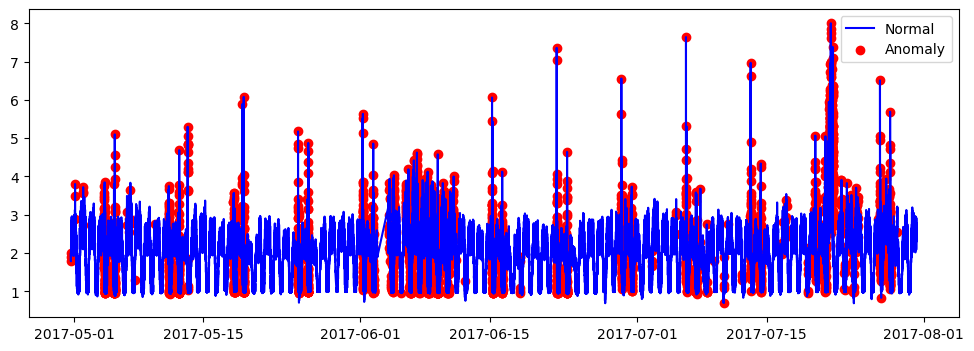

In [14]:
plot_outlier(if_prediction_df)

In [15]:
print_metrics(df, if_prediction_df)

F1 Score: 0.4967626394820224
Recall: 0.3413479742521772
Precision: 0.9119878603945372


## AutoEncoder

In [12]:
ae_clf = AutoEncoder(hidden_neurons =[4, 64, 64, 4], epochs=15)
ae_clf.fit(data)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 20        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0         
                                                                 
 dense_3 (Dense)             (None, 64)                3

2022-09-11 00:03:06.396873: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-11 00:03:06.396931: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-11 00:03:06.396958: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Madadi): /proc/driver/nvidia/version does not exist
2022-09-11 00:03:06.397447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


None
Epoch 1/15
48/48 [==============================] - 1s 4ms/step - loss: 1.4894 - val_loss: 1.4026
Epoch 2/15
48/48 [==============================] - 0s 2ms/step - loss: 1.4092 - val_loss: 1.3372
Epoch 3/15
48/48 [==============================] - 0s 2ms/step - loss: 1.3552 - val_loss: 1.2828
Epoch 4/15
48/48 [==============================] - 0s 2ms/step - loss: 1.3050 - val_loss: 1.2291
Epoch 5/15
48/48 [==============================] - 0s 2ms/step - loss: 1.2540 - val_loss: 1.1693
Epoch 6/15
48/48 [==============================] - 0s 2ms/step - loss: 1.2153 - val_loss: 1.1283
Epoch 7/15
48/48 [==============================] - 0s 1ms/step - loss: 1.1775 - val_loss: 1.0937
Epoch 8/15
48/48 [==============================] - 0s 1ms/step - loss: 1.1559 - val_loss: 1.0690
Epoch 9/15
48/48 [==============================] - 0s 1ms/step - loss: 1.1324 - val_loss: 1.0470
Epoch 10/15
48/48 [==============================] - 0s 1ms/step - loss: 1.1094 - val_loss: 1.0224
Epoch 11/15
48

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=15,
      hidden_activation='relu', hidden_neurons=[4, 64, 64, 4],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7f88714bfa30>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

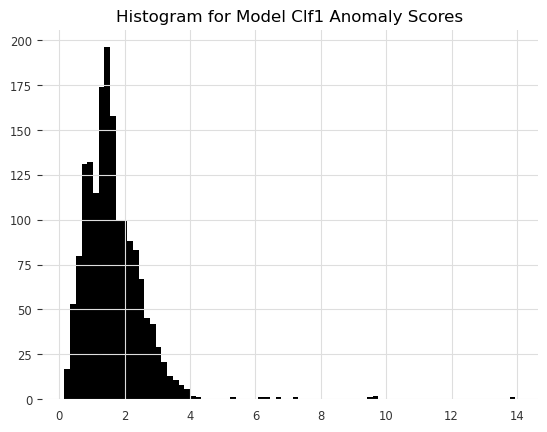

In [13]:
plt.hist(ae_clf.decision_scores_, bins='auto')
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

In [14]:
# Best fit score number is 1.54
ae_prediction_df = data.copy()
ae_prediction_df['score'] = ae_clf.decision_scores_ # outlier score
# ae_prediction_df['prediction'] = np.where(ae_prediction_df['score'] < 4.8, 0, 1)
ae_prediction_df['prediction'] = ae_clf.predict(data)
ae_prediction_df['prediction'].value_counts()
# df['label'].value_counts()
# ae_prediction_df.groupby('prediction').mean()

53/53 [==============================] - 0s 582us/step


0    1512
1     168
Name: prediction, dtype: int64

#### Visualization

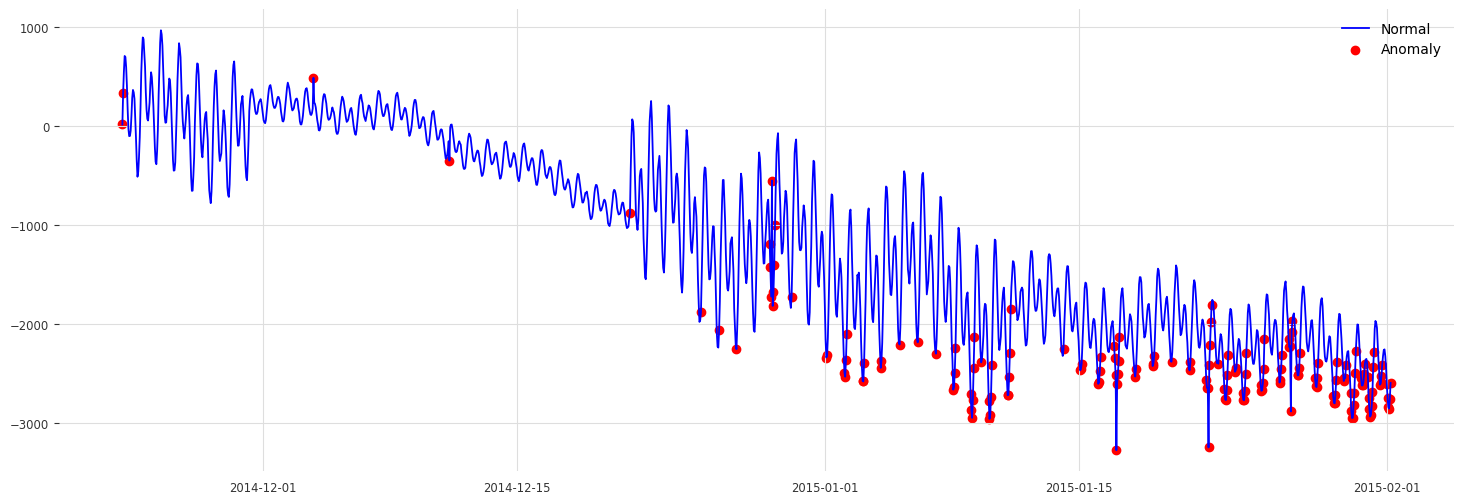

In [15]:
plot_outlier(ae_prediction_df)

#### Metrics

In [17]:
print_metrics(df, ae_prediction_df)

F1 Score: 0.0689655172413793
Recall: 1.0
Precision: 0.03571428571428571


## VAE

In [31]:
vae_clf = VAE(encoder_neurons=[4, 32, 64], decoder_neurons=[64, 32, 4], epochs=15)

vae_clf.fit(data, df['label'])

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense_29 (Dense)               (None, 4)            20          ['input_5[0][0]']                
                                                                                                  
 dense_30 (Dense)               (None, 4)            20          ['dense_29[0][0]']               
                                                                                                  
 dropout_18 (Dropout)           (None, 4)            0           ['dense_30[0][0]']               
                                                                                            

/home/madadi/anaconda3/envs/main/lib/python3.10/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


 mbda)                                                            'tf.math.multiply_8[0][0]']     
                                                                                                  
 tf.math.reduce_mean_5 (TFOpLam  ()                  0           ['tf.__operators__.add_5[0][0]'] 
 bda)                                                                                             
                                                                                                  
 add_loss_2 (AddLoss)           ()                   0           ['tf.math.reduce_mean_5[0][0]']  
                                                                                                  
Total params: 5,002
Trainable params: 5,002
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/15
48/48 [==============================] - 1s 4ms/step - loss: 5.3435 - val_loss: 5.3033
Epoch 2/15
48/48 [========================

VAE(batch_size=32, capacity=0.0, contamination=0.1,
  decoder_neurons=[64, 32, 4], dropout_rate=0.2,
  encoder_neurons=[4, 32, 64], epochs=15, gamma=1.0,
  hidden_activation='relu', l2_regularizer=0.1, latent_dim=2,
  loss=<function mean_squared_error at 0x7f88714bfa30>, optimizer='adam',
  output_activation='sigmoid', preprocessing=True, random_state=None,
  validation_size=0.1, verbose=1)

In [32]:
outlier_predict = vae_clf.predict(data)

53/53 [==============================] - 0s 781us/step


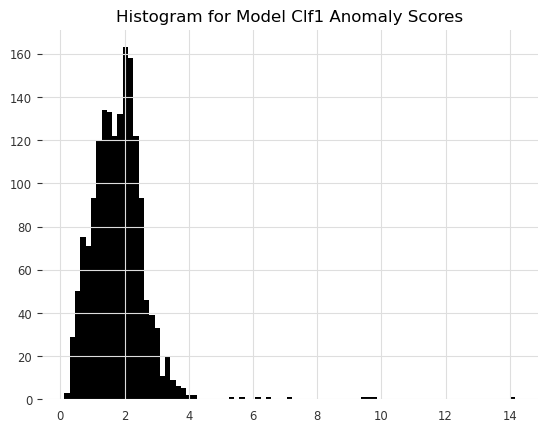

In [33]:
plt.hist(vae_clf.decision_scores_, bins='auto')
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

In [34]:
# Best fit score number is 1.54
vae_prediction_df = df.copy()
vae_prediction_df['score'] = vae_clf.decision_scores_
# vae_prediction_df['prediction'] = np.where(vae_prediction_df['score'] < 4.5, 0, 1)
vae_prediction_df['prediction'] = vae_clf.predict(data)
vae_prediction_df['prediction'].value_counts()
# df['label'].value_counts()
# ae_prediction_df.groupby('prediction').mean()

53/53 [==============================] - 0s 678us/step


0    1511
1     169
Name: prediction, dtype: int64

#### Visualization

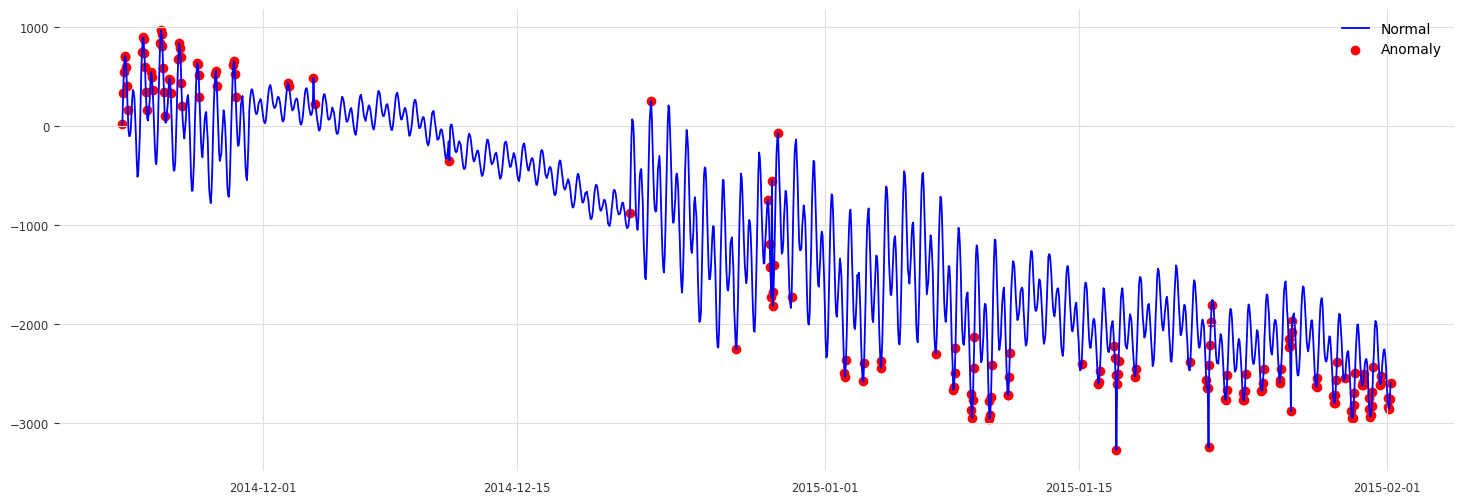

In [35]:
plot_outlier(vae_prediction_df)

#### Metrics

In [36]:
print_metrics(df, vae_prediction_df)

F1 Score: 0.06857142857142857
Recall: 1.0
Precision: 0.03550295857988166
